In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Mai 30

@author: yaning
"""

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
import matplotlib.pyplot as plt

2025-06-03 14:16:39.286184: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-03 14:16:39.362851: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-03 14:16:39.425434: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748952999.479746 2464724 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748952999.496823 2464724 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748952999.620425 2464724 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
def gabor_kernel(size=7, sigma=2.0, Lambda=3.0, psi=0, gamma=0.5, theta=0):
    """Generate a 2D Gabor filter kernel."""
    half = size // 2
    y, x = np.meshgrid(range(-half, half+1), range(-half, half+1))
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)
    gb = np.exp(-0.5 * (x_theta**2 + (gamma**2) * y_theta**2) / (sigma**2)) * np.cos(2 * np.pi * x_theta / Lambda + psi)
    return gb

# Generate 6 filters rotated by 0°, 30°, 60°, 90°, 120°, 150°
angles = np.deg2rad(np.arange(0, 180, 30))
filters = np.stack([gabor_kernel(theta=angle) for angle in angles], axis=-1)  # shape (size, size, 6)

# Conv2D weights shape: (kernel_h, kernel_w, input_channels, output_channels)
filters = filters[:, :, np.newaxis, :]  # add input channel dim = 1

# Normalize filters to zero mean and unit norm (optional)
filters -= filters.mean(axis=(0,1), keepdims=True)
filters /= np.linalg.norm(filters, axis=(0,1), keepdims=True) + 1e-10

In [28]:
filters.shape

(7, 7, 1, 6)

In [31]:
filters[:,:,0,1]

array([[-0.02174419,  0.02249541,  0.09469345,  0.08707335, -0.04468757,
        -0.15858497, -0.10371147],
       [ 0.07264341,  0.10610539, -0.00333992, -0.18242275, -0.19472878,
         0.01176701,  0.18749678],
       [ 0.03579352, -0.13692813, -0.23556081, -0.06543014,  0.21335722,
         0.26131057,  0.05637405],
       [-0.18943673, -0.12347533,  0.15203279,  0.31781569,  0.15203279,
        -0.12347533, -0.18943673],
       [ 0.05637405,  0.26131057,  0.21335722, -0.06543014, -0.23556081,
        -0.13692813,  0.03579352],
       [ 0.18749678,  0.01176701, -0.19472878, -0.18242275, -0.00333992,
         0.10610539,  0.07264341],
       [-0.10371147, -0.15858497, -0.04468757,  0.08707335,  0.09469345,
         0.02249541, -0.02174419]])

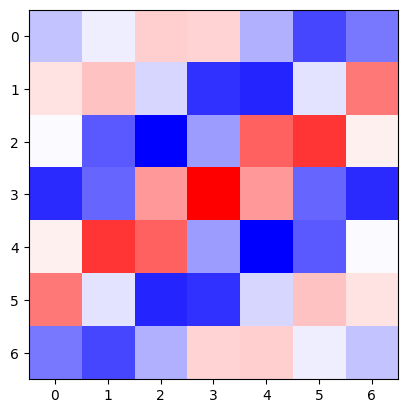

In [35]:
plt.imshow(filters[:,:,0,1], cmap='bwr')

In [3]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [24]:
gabor_data = []
for pic in x_train:
    img = np.expand_dims(pic, axis=0)
    feature_maps = tf.nn.conv2d(img, filters, strides=3, padding='SAME')
    gabor_data.append(feature_maps[0])

In [25]:
gabor_data = np.array(gabor_data)

In [26]:
gabor_data.shape

(60000, 10, 10, 6)

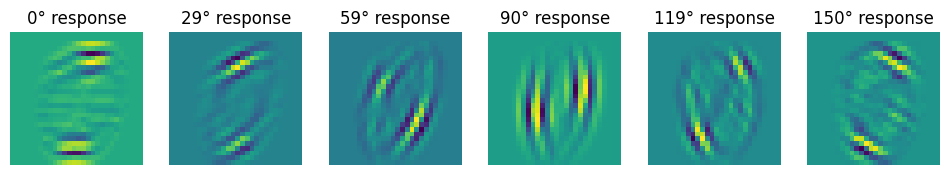

In [7]:
plt.figure(figsize=(12,3))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(gabor_data[1000,:,:,i], cmap='viridis')
    plt.title(f"{int(np.rad2deg(angles[i]))}° response")
    plt.axis('off')
plt.show()

In [9]:
test = np.expand_dims(x_train[5], axis=0)

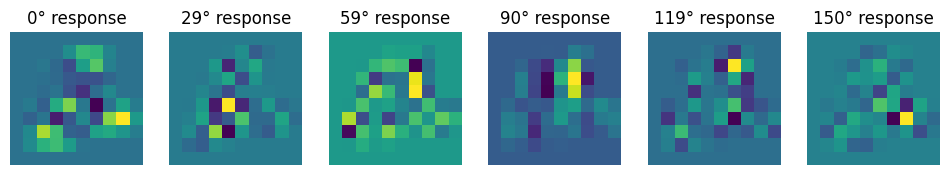

In [22]:
feature_maps = tf.nn.conv2d(test, filters, strides=3, padding='SAME')

plt.figure(figsize=(12,3))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(feature_maps[0,:,:,i], cmap='viridis')
    plt.title(f"{int(np.rad2deg(angles[i]))}° response")
    plt.axis('off')
plt.show()

In [23]:
feature_maps.shape

TensorShape([1, 10, 10, 6])

In [27]:
import pickle
path = "/home/yaning/Documents/"

with open(path + "gabor_data_10.pkl", "wb") as f:
    pickle.dump(gabor_data, f)